https://www.kaggle.com/datasets/msambare/fer2013

# 1. Load Dependency

## 1.1 Load Code from Github

In [ ]:
#!rm -rf Data_Mining
!git clone https://github.com/VinceTruong/Data_Mining.git

## 1.2 Load necessaty tools and libraries

In [1]:
import os
import time
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, roc_curve, auc, accuracy_score
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform

from keras.models import Sequential
from keras import regularizers
from keras.layers import AveragePooling2D, Add, Dense, Conv2D, MaxPool2D , Flatten, Dropout, BatchNormalization, Input, ZeroPadding2D, Activation, MaxPooling2D

import warnings
warnings.filterwarnings("ignore")

In [2]:
train_path = "Data_Mining/dataset/train"
test_ds = "Data_Mining/dataset/test"

# 2. Load and explore dataset

## 2.1 General Exploration

In [3]:
os.listdir(train_path) # 7 categories

['neutral', 'surprise', 'sad', 'disgust', 'fear', 'happy', 'angry']

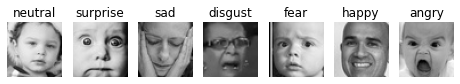

In [4]:
# explore the image and labels
i = 1
plt.figure(figsize=(8,8))
for expression in os.listdir(train_path):
    img = load_img((train_path +'/'+ expression +'/'+ os.listdir(train_path + '/' + expression)[1]))
    plt.subplot(1,7,i)
    plt.imshow(img)
    plt.title(expression)
    plt.axis('off')
    i += 1
    
plt.show()

## 2.2 Train - Validation - Test Split

In [5]:
# The data consists of 48x48 pixel grayscale images of faces.
batch_size = 256
img_height = 48
img_width = 48

In [6]:
# Load train, validation, test from directory
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels = "inferred",
    validation_split = 0.2,
    subset = 'training',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

val_ds = tf.keras.utils.image_dataset_from_directory(
    directory = train_path,
    labels = "inferred",
    validation_split = 0.2,
    subset = 'validation',
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

test_ds = tf.keras.utils.image_dataset_from_directory(
    directory = test_ds,
    labels = "inferred",
    seed=123,
    image_size=(img_height, img_width),
    #batch_size=batch_size,
    color_mode='grayscale',
    label_mode="categorical")

Found 28522 files belonging to 7 classes.
Using 22818 files for training.


2022-12-06 01:10:15.827290: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 01:10:15.828157: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 01:10:15.829461: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 01:10:15.830231: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-12-06 01:10:15.830976: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Found 28522 files belonging to 7 classes.
Using 5704 files for validation.
Found 7101 files belonging to 7 classes.


In [16]:
train_ds.class_names

['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

## 2.3 Normalize dataset

In [26]:
train_ds_normal = train_ds.map(lambda x,y: (x/255, y))
val_ds_normal = val_ds.map(lambda x,y: (x/255, y))
test_ds_normal = test_ds.map(lambda x,y: (x/255, y))

In [7]:
#train dataset
trainX, trainY = zip(*train_ds)
trainX = np.concatenate([x for x in trainX], axis = 0)
trainY = np.concatenate([y for y in trainY], axis = 0)
#validation dataset
valX, valY = tuple(zip(*val_ds))
valX = np.concatenate([x for x in valX], axis = 0)
valY = np.concatenate([y for y in valY], axis = 0)
#test datasett
testX, testY = tuple(zip(*test_ds))
testX = np.concatenate([x for x in testX], axis = 0)
testY = np.concatenate([y for y in testY], axis = 0)

2022-12-06 01:10:19.800841: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


In [8]:
print(trainX.shape)
print(trainY.shape)

print(valX.shape)
print(valY.shape)

print(testX.shape)
print(testY.shape)

(22818, 48, 48, 1)
(22818, 7)
(5704, 48, 48, 1)
(5704, 7)
(7101, 48, 48, 1)
(7101, 7)


neutral


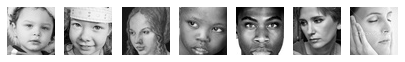

surprise


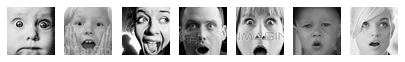

sad


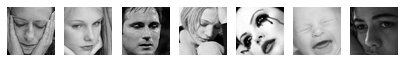

disgust


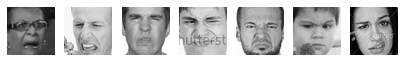

fear


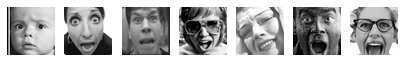

happy


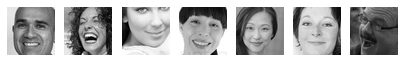

angry


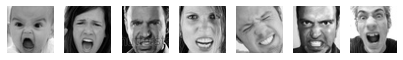

In [9]:
# Explore 7 data samples for each category
i = 1
for expression in os.listdir(train_path):
    plt.figure(figsize=(7,7))
    print(expression)
    for j in range(1, 8):
        img = load_img((train_path +'/'+ expression +'/'+ os.listdir(train_path + '/' + expression)[j]))
        plt.subplot(i,7,j)
        plt.imshow(img)
        plt.axis('off')
    i += 1
    plt.show()

## 2.4 Visualisation

In [10]:
train_category = list(np.sum(trainY, axis=0).astype('int64'))
print(train_category)

[3198, 340, 3267, 5784, 3899, 3831, 2499]


In [11]:
test_category = list(np.sum(testY, axis=0).astype('int64'))
print(test_category)

[944, 108, 1007, 1759, 1223, 1234, 826]


In [17]:
train_category.sort(reverse=True)
facial = ['happy', 'neutral', 'sad', 'fear', 'angry', 'surprise','disgust']

#print(category)
dic_train = {facial[i]: train_category[i] for i in range(7)}
print(dic_train)

{'happy': 5784, 'neutral': 3899, 'sad': 3831, 'fear': 3267, 'angry': 3198, 'surprise': 2499, 'disgust': 340}


In [18]:
test_category.sort(reverse=True)

#print(category)
dic_test = {facial[i]: test_category[i] for i in range(7)}
print(dic_test)

{'happy': 1759, 'neutral': 1234, 'sad': 1223, 'fear': 1007, 'angry': 944, 'surprise': 826, 'disgust': 108}


In [19]:
#Training set
fig = go.Figure(data=[go.Bar(x=list(dic_train.keys()), 
                              y=list(dic_train.values()))])
fig

In [20]:
#Test set
fig = go.Figure(data=[go.Bar(x=list(dic_test.keys()), 
                              y=list(dic_test.values()))])
fig

# 3. Model Experiment


## 3.1 Define some Plot functions

In [21]:
y_test = np.argmax(testY, axis = 1)

In [22]:
args = {
    "epochs": 20,
    "batches": 256,
    "lr": 0.0001
}
adm = Adam(learning_rate=args["lr"])

In [23]:
# roc_curve definition
def plot_multiclass_roc(y_predict, y_test):

    # structures
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    # calculate dummies once
    
    for i in range(7):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_predict[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # roc for each class
    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver operating characteristic example')
    for i in range(7):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], test_ds.class_names[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()

#plot_multiclass_roc()

In [24]:
# confustion matrix for model result
def plot_confusion_matrix(actual, predicted, labels, ds_type):
    cm = tf.math.confusion_matrix(actual, predicted)
    ax = sns.heatmap(cm, annot=True, fmt='g', cmap = 'Blues')
    sns.set(rc={'figure.figsize':(10, 10)})
    sns.set(font_scale=1.4)
    ax.set_title('Confusion matrix of action recognition for ' + ds_type)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0) 
    ax.xaxis.set_ticklabels(labels)
    ax.yaxis.set_ticklabels(labels)
    
labels = ['angry', 'digust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

## 3.2 Alex Net

Epoch 1/20


2022-12-06 01:13:33.189449: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


90/90 [==============================] - 36s 300ms/step - loss: 2.4421 - accuracy: 0.2776 - val_loss: 1.9060 - val_accuracy: 0.1855
Epoch 2/20
90/90 [==============================] - 26s 285ms/step - loss: 1.6259 - accuracy: 0.3670 - val_loss: 2.1785 - val_accuracy: 0.2037
Epoch 3/20
90/90 [==============================] - 26s 281ms/step - loss: 1.4910 - accuracy: 0.4223 - val_loss: 2.3193 - val_accuracy: 0.1760
Epoch 4/20
90/90 [==============================] - 26s 283ms/step - loss: 1.3995 - accuracy: 0.4612 - val_loss: 2.1046 - val_accuracy: 0.2156
Epoch 5/20
90/90 [==============================] - 26s 288ms/step - loss: 1.3287 - accuracy: 0.4887 - val_loss: 1.6644 - val_accuracy: 0.3561
Epoch 6/20
90/90 [==============================] - 26s 288ms/step - loss: 1.2591 - accuracy: 0.5253 - val_loss: 1.3727 - val_accuracy: 0.4639
Epoch 7/20
90/90 [==============================] - 26s 287ms/step - loss: 1.1992 - accuracy: 0.5462 - val_loss: 1.2612 - val_accuracy: 0.5075
Epoch 8/20

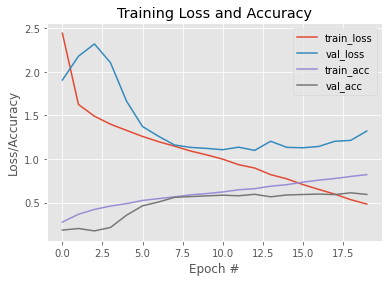

In [27]:
#AlexNet
def process_images(image,label):
    # Normalize images to have a mean of 0 and standard deviation of 1
    image = tf.image.per_image_standardization(image)
    # Resize images from 48x48 to 277x277
    image = tf.image.resize(image, (227,227))
    return image,label

train_alex = train_ds.map(process_images)
                    

val_alex =val_ds.map(process_images)
                

test_alex = test_ds.map(process_images)
               

AlexNet = Sequential()
AlexNet.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(227,227,1)))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
AlexNet.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
AlexNet.add(BatchNormalization())
AlexNet.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
AlexNet.add(BatchNormalization())
AlexNet.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"))
AlexNet.add(BatchNormalization())
AlexNet.add(MaxPool2D(pool_size=(3,3), strides=(2,2)))
AlexNet.add(Flatten())
AlexNet.add(Dense(4096, activation='relu'))
AlexNet.add(Dropout(0.5))
AlexNet.add(Dense(4096, activation='relu'))
AlexNet.add(Dropout(0.5))
AlexNet.add(Dense(7, activation='softmax'))
#AlexNet.summary()

AlexNet.compile(optimizer=adm, loss='categorical_crossentropy', metrics=['accuracy'])
AlexNethistory = AlexNet.fit(train_alex, epochs=args["epochs"], batch_size=args["batches"],validation_data=val_alex)

# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, args["epochs"]), AlexNethistory.history["loss"], label="train_loss")
plt.plot(np.arange(0, args["epochs"]), AlexNethistory.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, args["epochs"]), AlexNethistory.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, args["epochs"]), AlexNethistory.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()


In [28]:
y_predict_alex = AlexNet.predict(test_alex)
y_predict_alex_label = np.argmax(y_predict_alex, axis = 1)

In [29]:
print(classification_report(y_test,y_predict_alex_label, target_names=labels))

              precision    recall  f1-score   support

       angry       0.13      0.13      0.13       944
      digust       0.07      0.04      0.05       108
        fear       0.14      0.11      0.12      1007
       happy       0.25      0.25      0.25      1759
     neutral       0.18      0.14      0.16      1223
         sad       0.18      0.28      0.22      1234
    surprise       0.13      0.11      0.12       826

    accuracy                           0.18      7101
   macro avg       0.15      0.15      0.15      7101
weighted avg       0.18      0.18      0.18      7101



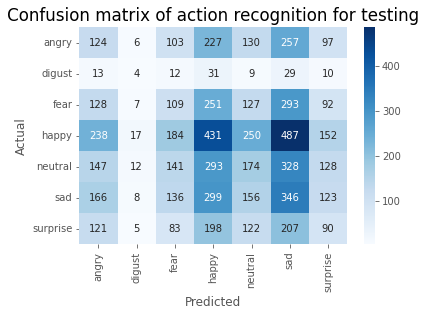

In [30]:
plot_confusion_matrix(y_test, y_predict_alex_label, labels, 'testing')

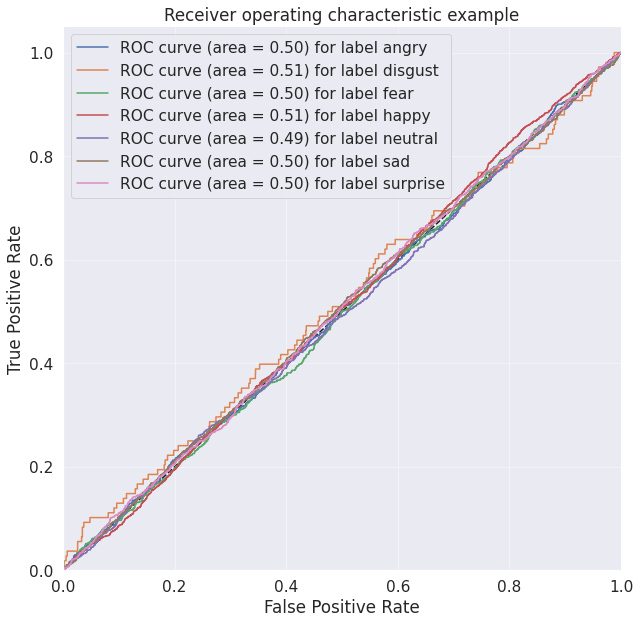

In [31]:
plot_multiclass_roc(y_predict_alex, testY)

## 3.3 VGG16

VGG16 is convolutional neutral network introduced by K. Simonyan and A. Zisserman, who won a ILSVR(Imagenet) competition in 2014. 

Instead of using large number of hyper-parameter, it feature is using convolution layer of 3x3 filter with stride 1 and same padding, along with maxpool layer of 2x2 filter of stride 2.  

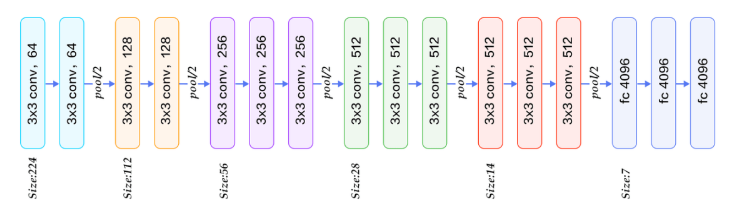

In [32]:
# Creating model
VGG = Sequential()

# 2 x convolution layer of 64 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(input_shape=((48, 48, 1)),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 2 x convolution layer of 128 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 256 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 512 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# 3 x convolution layer of 512 filters of size 3x3  +  1 x maxpool layer 2x2
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
VGG.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))


# After several convolution layers and pooling layer, data has been flatten and loaded into fully connected layer
# 2 x Dense layers of 4096 units  +  1 x Dense Softmax layer of 7 units
VGG.add(Flatten())
VGG.add(Dense(units=4096,activation="relu"))
VGG.add(Dense(units=4096,activation="relu"))
VGG.add(Dense(units=7, activation="softmax"))

In [37]:

adm = Adam(learning_rate=args["lr"])
VGG.compile(loss="categorical_crossentropy", optimizer=adm, metrics=["accuracy"])

H = VGG.fit(x = trainX, y= trainY, validation_data=(valX, valY), epochs=args["epochs"], batch_size=args["batches"], callbacks=callbacks)



Epoch 1/20
90/90 [==============================] - 21s 227ms/step - loss: 1.8172 - accuracy: 0.2521 - val_loss: 1.8502 - val_accuracy: 0.2502
Epoch 2/20
90/90 [==============================] - 18s 205ms/step - loss: 1.6233 - accuracy: 0.3541 - val_loss: 1.4771 - val_accuracy: 0.4283
Epoch 3/20
90/90 [==============================] - 18s 204ms/step - loss: 1.4300 - accuracy: 0.4414 - val_loss: 1.3805 - val_accuracy: 0.4549
Epoch 4/20
90/90 [==============================] - 18s 203ms/step - loss: 1.3056 - accuracy: 0.4948 - val_loss: 1.2931 - val_accuracy: 0.5021
Epoch 5/20
90/90 [==============================] - 18s 202ms/step - loss: 1.1971 - accuracy: 0.5417 - val_loss: 1.2665 - val_accuracy: 0.5130
Epoch 6/20
90/90 [==============================] - 18s 203ms/step - loss: 1.1104 - accuracy: 0.5737 - val_loss: 1.2613 - val_accuracy: 0.5082
Epoch 7/20
90/90 [==============================] - 18s 204ms/step - loss: 0.9955 - accuracy: 0.6199 - val_loss: 1.2749 - val_accuracy: 0.5473

In [38]:
y_predict_vgg = VGG.predict(testX)
y_predict_vgg_label = np.argmax(y_predict_vgg, axis = 1)

In [39]:
accuracy_score(y_test, y_predict_vgg_label)

0.5748486128714265

In [40]:
print(classification_report(y_test, y_predict_vgg_label, target_names = labels))

              precision    recall  f1-score   support

       angry       0.49      0.46      0.48       944
      digust       0.83      0.42      0.56       108
        fear       0.37      0.47      0.42      1007
       happy       0.79      0.80      0.80      1759
     neutral       0.52      0.51      0.51      1223
         sad       0.44      0.44      0.44      1234
    surprise       0.84      0.67      0.74       826

    accuracy                           0.57      7101
   macro avg       0.61      0.54      0.56      7101
weighted avg       0.59      0.57      0.58      7101



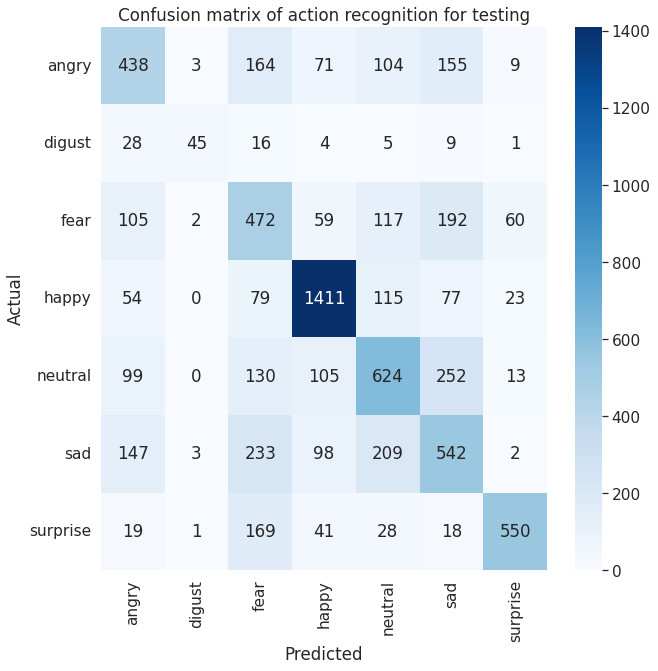

In [41]:
plot_confusion_matrix(y_test, y_predict_vgg_label, labels, 'testing')

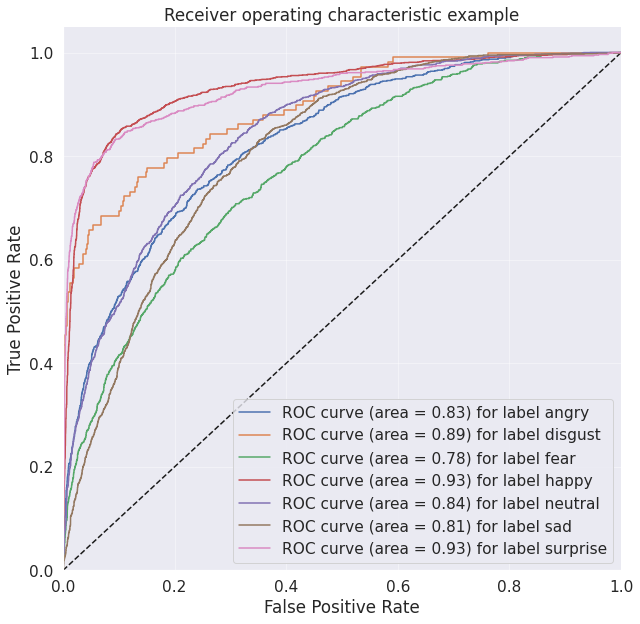

In [42]:
plot_multiclass_roc(y_predict_vgg, testY)

# 4. Conclusion

After training two models, we can infer that:
- AlexNet Model: high accuracy on training and validation set, but low accuracy, F1 score on test set (as shown in classification report, ROC curve and confusion matrix)
- VGG16 Model: though performing very well on training set (0.99 accurracy), it is overfitting on validation set (the more epoches, the more loss value is). However, its performance on test set is acceptable since F1 score and accuracy are higher than that of other two models.  